# Anonymisation with Synthetic Data Tutorial


## Generate mock NHS A&E dataset


Then, to generate the data, from the project root directory run the `generate.py` script.

Voila! You'll now see a new `hospital_ae_data.csv` file in the `/data` directory. Open it up and have a browse. It's contains the following columns:

- **Health Service ID**: NHS number of the admitted patient  
- **Age**: age of patient
- **Time in A&E (mins)**: time in minutes of how long the patient spent in A&E. This is generated to correlate with the age of the patient.
- **Hospital**: which hospital admitted the patient - with some hospitals being more prevalent in the data than others
- **Arrival Time**: what time and date the patient was admitted - with weekends as busier and and a different peak time for each day
- **Treatment**: what the person was treated for - with certain treatments being more common than others
- **Gender**: patient gender - based on [NHS patient gender codes](https://www.datadictionary.nhs.uk/data_dictionary/attributes/p/person/person_gender_code_de.asp?shownav=1)
- **Postcode**: postcode of patient - random, in use, London postcodes extracted from the `London postcodes.csv` file.

We can see this dataset obviously contains some personal information. For instance, if we knew roughly the time a neighbour went to A&E we could use their postcode to figure out exactly what ailment they went in with. Or, if a list of people's Health Service ID's were to be leaked in future, lots of people could be re-identified.

Because of this, we'll need to take some de-identification steps.

---


In [1]:
from generate import generate_fake_dataset
from deidentify import deindentify
import filepaths
import pandas as pd
import seaborn as sns

In [2]:
hospital_ae_df = generate_fake_dataset()

generating data...
generating Health Service ID numbers...
generating patient ages and times in A&E...
[[10000     0]
 [    0 10000]]
generating hospital instances...
generating arrival times...
generating A&E treaments...
generating patient gender instances...
generating patient postcodes...
done in 1.29 seconds.


In [3]:
hospital_ae_df.head()

,Health Service ID,Age,Time in A&E (mins),Hospital,Arrival Time,Treatment,Gender,Postcode
0,503-053-9940,9.572203,1.000000,University Hospital Lewisham,2019-04-03 11:15:50,Nebuliser/spacer,Female,NW11 9DN
1,393-922-2789,43.283094,-9.317759,West Middlesex University Hospital,2019-04-06 13:44:06,Wound closure (excluding sutures),Male,EC1R 4QS
2,817-167-8706,68.235535,4.329889,Charing Cross Hospital,2019-04-02 21:21:14,Infusion fluids,Male,HA5 2YU
3,036-348-5325,11.372672,17.963540,Queen Elizabeth Hospital,2019-04-02 09:40:59,Central line,Male,KT1 9DF
4,388-598-6916,-12.459172,-25.688624,Homerton University Hospital,2019-04-04 16:51:25,Wound closure (excluding sutures),Male,NW7 0EF


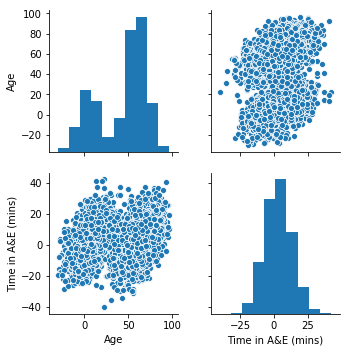

In [4]:
sns.pairplot(hospital_ae_df)

## De-identification

For this stage, we're going to be loosely following the de-identification techniques used by Jonathan Pearson of NHS England, and described in a blog post about [creating its own synthetic data](https://odileeds.org/blog/2019-01-24-exploring-methods-for-creating-synthetic-a-e-data).

### Remove Health Service ID numbers

Health Service ID numbers are direct identifiers and should be removed. So we'll simply drop the entire column.

```python
hospital_ae_df = hospital_ae_df.drop('Health Service ID', 1)
```

### Where a patient lives

Pseudo-identifiers, also known as [quasi-identifiers](https://en.wikipedia.org/wiki/Quasi-identifier), are pieces of information that don't directly identify people but can used with other information to identify a person. If we were to take the age, postcode and gender of a person we could combine these and check the dataset to see what that person was treated for in A&E.

The data scientist from NHS England, Jonathan Pearson, describes this in the blog post:

> I started with the postcode of the patients resident lower super output area (LSOA). This is a geographical definition with an average of 1500 residents created to make reporting in England and Wales easier. I wanted to keep some basic information about the area where the patient lives whilst completely removing any information regarding any actual postcode. A key variable in health care inequalities is the patients Index of Multiple deprivation (IMD) decile (broad measure of relative deprivation) which gives an average ranked value for each LSOA. By replacing the patients resident postcode with an IMD decile I have kept a key bit of information whilst making this field non-identifiable.

We'll do just the same with our dataset.

First we'll map the rows' postcodes to their LSOA and then drop the postcodes column.

```python
postcodes_df = pd.read_csv(filepaths.postcodes_london)
hospital_ae_df = pd.merge(
    hospital_ae_df,
    postcodes_df[['Postcode', 'Lower layer super output area']],
    on='Postcode'
)
hospital_ae_df = hospital_ae_df.drop('Postcode', 1)
```

Then we'll add a mapped column of "Index of Multiple Deprivation" column for each entry's LSOA.

```python
hospital_ae_df = pd.merge(
    hospital_ae_df,
    postcodes_df[['Lower layer super output area', 'Index of Multiple Deprivation']].drop_duplicates(),
    on='Lower layer super output area'
)
```

Next calculate the decile bins for the IMDs by taking all the IMDs from large list of London. We'll use the Pandas `qcut` (quantile cut), function for this.

```python
_, bins = pd.qcut(
    postcodes_df['Index of Multiple Deprivation'],
    10,
    retbins=True,
    labels=False
)
```

Then we'll use those decile `bins` to map each row's IMD to its IMD decile.

```python
# add +1 to get deciles from 1 to 10 (not 0 to 9)
hospital_ae_df['Index of Multiple Deprivation Decile'] = pd.cut(
    hospital_ae_df['Index of Multiple Deprivation'],
    bins=bins,
    labels=False,
    include_lowest=True) + 1
```

And finally drop the columns we no longer need.

```python
hospital_ae_df = hospital_ae_df.drop('Index of Multiple Deprivation', 1)
hospital_ae_df = hospital_ae_df.drop('Lower layer super output area', 1)
```

### Individual hospitals

The data scientist at NHS England masked individual hospitals giving the following reason.

> As each hospital has its own complex case mix and health system, using these data to identify poor performance or possible improvements would be invalid and un-helpful. Therefore, I decided to replace the hospital code with a random number.

So we'll do as they did, replacing hospitals with a random six-digit ID.

```python
hospitals = hospital_ae_df['Hospital'].unique().tolist()
random.shuffle(hospitals)
hospitals_map = {
    hospital : ''.join(random.choices(string.digits, k=6))
    for hospital in hospitals
}
hospital_ae_df['Hospital ID'] = hospital_ae_df['Hospital'].map(hospitals_map)
```

And remove the `Hospital` column.

```python
hospital_ae_df = hospital_ae_df.drop('Hospital', 1)
```

### Time in the data

> The next obvious step was to simplify some of the time information I have available as health care system analysis doesn't need to be responsive enough to work on a second and minute basis. Thus, I removed the time information from the 'arrival date', mapped the 'arrival time' into 4-hour chunks

First we'll split the `Arrival Time` column in to `Arrival Date` and `Arrival Hour`.

```python
arrival_times = pd.to_datetime(hospital_ae_df['Arrival Time'])
hospital_ae_df['Arrival Date'] = arrival_times.dt.strftime('%Y-%m-%d')
hospital_ae_df['Arrival Hour'] = arrival_times.dt.hour
hospital_ae_df = hospital_ae_df.drop('Arrival Time', 1)
```

Then we'll map the hours to 4-hour chunks and drop the `Arrival Hour` column.

```python
hospital_ae_df['Arrival hour range'] = pd.cut(
    hospital_ae_df['Arrival Hour'],
    bins=[0, 4, 8, 12, 16, 20, 24],
    labels=['00-03', '04-07', '08-11', '12-15', '16-19', '20-23'],
    include_lowest=True
)
hospital_ae_df = hospital_ae_df.drop('Arrival Hour', 1)
```

### Patient demographics

> I decided to only include records with a sex of male or female in order to reduce risk of re identification through low numbers.

```python
hospital_ae_df = hospital_ae_df[hospital_ae_df['Gender'].isin(['Male', 'Female'])]
```

> For the patients age it is common practice to group these into bands and so I've used a standard set - 1-17, 18-24, 25-44, 45-64, 65-84, and 85+ - which although are non-uniform are well used segments defining different average health care usage.

```python
hospital_ae_df['Age bracket'] = pd.cut(
    hospital_ae_df['Age'],
    bins=[0, 18, 25, 45, 65, 85, 150],
    labels=['0-17', '18-24', '25-44', '45-64', '65-84', '85-'],
    include_lowest=True
)
hospital_ae_df = hospital_ae_df.drop('Age', 1)
```

That's all the steps we'll take. We'll finally save our new de-identified dataset.

In [5]:
hospital_ae_data_deidentify = deindentify(hospital_ae_df)

running de-identification steps...
removing Health Service ID numbers...
converting postcodes to LSOA...
converting LSOA to IMD decile...
replacing Hospital with random number...
putting Arrival Hour in 4-hour bins...
removing non-male-or-female from gender ...
putting ages in age brackets...
done in 2.18 seconds.


In [6]:
hospital_ae_data_deidentify.head()

,Time in A&E (mins),Treatment,Gender,Index of Multiple Deprivation Decile,Hospital ID,Arrival Date,Arrival hour range,Age bracket
0,1.000000,Nebuliser/spacer,Female,7,712141,2019-04-03,08-11,0-17
1,4.168928,Bandage/support,Female,7,582340,2019-04-05,04-07,45-64
2,0.466646,Wound cleaning,Male,7,712141,2019-04-06,08-11,45-64
3,2.202209,Removal foreign body,Female,7,712141,2019-04-07,04-07,65-84
4,-9.317759,Wound closure (excluding sutures),Male,4,773925,2019-04-06,12-15,25-44


## Synthesise

Synthetic data exists on a spectrum from merely the same columns and datatypes as the original data all the way to carrying nearly all of the statistical patterns of the original dataset.

The UK's Office of National Statistics has a great report on synthetic data and the [_Synthetic Data Spectrum_](https://www.ons.gov.uk/methodology/methodologicalpublications/generalmethodology/onsworkingpaperseries/onsmethodologyworkingpaperseriesnumber16syntheticdatapilot?utm_campaign=201903_UK_DataPolicyNetwork&utm_source=hs_email&utm_medium=email&utm_content=70377606&_hsenc=p2ANqtz-9W6ByBext_HsgkTPG1lw2JJ_utRoJSTIeVC5Z2lz3QkzwFQpZ0dp2ns9SZLPqxLJrgWzsjC_zt7FQcBvtIGoeSjZtwNg&_hsmi=70377606#synthetic-dataset-spectrum) section is very good in explaining the nuances in more detail.

In this tutorial we'll create not one, not two, but *three* synthetic datasets, that are on a range across the synthetic data spectrum: *Random*, *Independent* and *Correlated*.

> In **correlated attribute mode**, we learn a differentially private Bayesian network capturing the correlation structure between attributes, then draw samples from this model to construct the result dataset.
>
> In cases where the correlated attribute mode is too computationally expensive or when there is insufficient data to derive a reasonable model, one can use **independent attribute mode**. In this mode, a histogram is derived for each attribute, noise is added to the histogram to achieve differential privacy, and then samples are drawn for each attribute.
>
> Finally, for cases of extremely sensitive data, one can use **random mode** that simply generates type-consistent random values for each attribute.

We'll go through each of these now, moving along the synthetic data spectrum, in the order of random to independent to correlated.

The toolkit we will be using to generate the three synthetic datasets is DataSynthetizer.

### DataSynthesizer

As described in the introduction, this is an open-source toolkit for generating synthetic data. And I'd like to lavish much praise on the researchers who made it as it's excellent.

Instead of explaining it myself, I'll use the researchers' own words from their paper:

> DataSynthesizer infers the domain of each attribute and derives a description of the distribution of attribute values in the private dataset. This information is saved in a dataset description file, to which we refer as data summary. Then DataSynthesizer is able to generate synthetic datasets of arbitrary size by sampling from the probabilistic model in the dataset description file.

We'll create and inspect our synthetic datasets using three modules within it.

> DataSynthesizer consists of three high-level modules:
>
> 1. **DataDescriber**: investigates the data types, correlations and distributions of the attributes in the private dataset, and produces a data summary.
> 2. **DataGenerator**: samples from the summary computed by DataDescriber and outputs synthetic data
> 3. **ModelInspector**: shows an intuitive description of the data summary that was computed by DataDescriber, allowing the data owner to evaluate the accuracy of the summarization process and adjust any parameters, if desired.

If you want to browse the code for each of these modules, you can find the Python classes for in the `DataSynthetizer` directory (all code in here from the [original repo](https://github.com/DataResponsibly/DataSynthesizer)).


### Random mode

If we were just to generate A&E data for testing our software, we wouldn't care too much about the statistical patterns within the data. Just that it was roughly a similar size and that the datatypes and columns aligned.

In this case, we can just generate the data at random using the `generate_dataset_in_random_mode` function within the `DataGenerator` class.

#### Data Description: Random

The first step is to create a description of the data, defining the datatypes and which are the categorical variables.

In [7]:
attribute_to_datatype = {
    'Time in A&E (mins)': 'Integer',
    'Treatment': 'String',
    'Gender': 'String',
    'Index of Multiple Deprivation Decile': 'Integer',
    'Hospital ID': 'String',
    'Arrival Date': 'String',
    'Arrival hour range': 'String',  
    'Age bracket': 'String'
}

attribute_is_categorical = {
    'Hospital ID': True,
    'Time in A&E (mins)': False,
    'Treatment': True,
    'Gender': True,
    'Index of Multiple Deprivation Decile': False,
    'Arrival Date': True,
    'Arrival hour range': True,  
    'Age bracket': True
}

In [8]:
import os
import sys
from pathlib import Path

#this_filepath = Path(os.path.realpath(__file__))
#project_root = str(this_filepath.parents[1])

#data_dir = os.path.join(project_root, 'DataSynthesizer/')
sys.path.insert(0, filepaths.data_synthesizer_dir)

import DataDescriber, DataGenerator, ModelInspector


In [9]:
describer = DataDescriber.DataDescriber()


describer.describe_dataset_in_random_mode(
    filepaths.hospital_ae_data_deidentify,
    attribute_to_datatype=attribute_to_datatype,
    attribute_to_is_categorical=attribute_is_categorical)

describer.save_dataset_description_to_file(
    filepaths.hospital_ae_description_random)

#### Data Generation: Random

Next, generate the random data. We'll just generate the same amount of rows as was in the original data but, importantly, we could generate much more or less if we wanted to.

In [10]:
num_rows = len(hospital_ae_df)
generator = DataGenerator.DataGenerator()


In [11]:
generator.generate_dataset_in_random_mode(
    num_rows, filepaths.hospital_ae_description_random)
generator.save_synthetic_data(filepaths.hospital_ae_data_synthetic_random)


#### Attribute Comparison: Random

We'll compare each attribute in the original data to the synthetic data by generating plots of histograms using the `ModelInspector` class.


In [12]:
synthetic_df = generator.synthetic_dataset

synthetic_df.head()

,Time in A&E (mins),Treatment,Gender,Index of Multiple Deprivation Decile,Hospital ID,Arrival Date,Arrival hour range,Age bracket
0,0,Nebuliser/spacer,Male,9,715637,2019-04-02,16-19,25-44
1,1,Removal foreign body,Male,28,296498,2019-04-05,00-03,0-17
2,2,Removal foreign body,Male,41,906621,2019-04-05,20-23,45-64
3,3,Urinary catheter/suprapubic,Female,86,296498,2019-04-07,20-23,25-44
4,4,Dental treatment,Male,3,818695,2019-04-02,16-19,25-44


In [14]:
# Read attribute description from the dataset description file.
from lib.utils import read_json_file


attribute_description = read_json_file(
    filepaths.hospital_ae_description_random)['attribute_description']

inspector = ModelInspector.ModelInspector(hospital_ae_data_deidentify, synthetic_df, attribute_description)

for attribute in synthetic_df.columns:

    try:
        inspector.compare_histograms(attribute, "plot/random_"+str(str.split(attribute)[0]))
    except:
        print ('Issue with '+attribute)


*Comparison of ages in original data (left) and random synthetic data (right)*
![Random mode age bracket histograms](../tutorial/plot/random_Age.png)

*Comparison of hospital attendance in original data (left) and random synthetic data (right)*
![Random mode age bracket histograms](../tutorial/plot/random_Hospital.png)

*Comparison of arrival date in original data (left) and random synthetic data (right)*
![Random mode age bracket histograms](../tutorial/plot/random_Treatment.png)


#### Compare pairwise mutual information: Random

DataSynthesizer has a function to compare the _mutual information_ between each of the variables in the dataset and plot them. We'll avoid the mathematical definition of mutual information but [Scholarpedia notes](http://www.scholarpedia.org/article/Mutual_information) it:


In [ ]:
inspector.mutual_information_heatmap('plot/mutual_information_heatmap_random')


We can see the original, private data has a correlation between `Age bracket` and `Time in A&E (mins)`. Not surprisingly, this correlation is lost when we generate our random data.

*Mutual Information Heatmap in original data (left) and random synthetic data (right)*
![Random mode age mutual information](plot/mutual_information_heatmap_random.png)

### Independent attribute mode

What if we had the use case where we wanted to build models to analyse the medians of ages, or hospital usage in the synthetic data? In this case we'd use independent attribute mode.

#### Data Description: Independent


In [ ]:
describer.describe_dataset_in_independent_attribute_mode(
    filepaths.hospital_ae_data_deidentify,
    attribute_to_datatype=attribute_to_datatype,
    attribute_to_is_categorical=attribute_is_categorical)
describer.save_dataset_description_to_file(
    filepaths.hospital_ae_description_independent)

#### Data Generation: Independent

Next generate the data which keep the distributions of each column but not the data correlations.

In [ ]:
generator = DataGenerator.DataGenerator()
generator.generate_dataset_in_independent_mode(
    num_rows, filepaths.hospital_ae_description_independent)
generator.save_synthetic_data(
    filepaths.hospital_ae_data_synthetic_independent)

#### Attribute Comparison: Independent

Comparing the attribute histograms we see the independent mode captures the distributions pretty accurately. You can see the synthetic data is _mostly_ similar but not exactly.


In [ ]:
synthetic_df = generator.synthetic_dataset
inspector = ModelInspector.ModelInspector(hospital_ae_data_deidentify, synthetic_df, attribute_description)

for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute, "plot/independent_"+str(str.split(attribute)[0]))



*Comparison of ages in original data (left) and independent synthetic data (right)*
![Random mode age bracket histograms](plot/independent_Age.png)

*Comparison of hospital attendance in original data (left) and independent synthetic data (right)*
![Random mode age bracket histograms](plot/independent_Hospital.png)

*Comparison of arrival date in original data (left) and independent synthetic data (right)*
![Random mode age bracket histograms](plot/independent_Arrival.png)



#### Compare pairwise mutual information: Independent


In [ ]:
inspector.mutual_information_heatmap('plot/independent_mutual_information')

We can see the independent data also does not contain any of the attribute correlations from the original data.

*Mutual Information Heatmap in original data (left) and independent synthetic data (right)*
![Independent mode mutual information](plot/independent_mutual_information.png)

### Correlated attribute mode - include correlations between columns in the data

If we want to capture correlated variables, for instance if patient is related to waiting times, we'll need correlated data. To do this we use *correlated mode*.

#### Data Description: Correlated

There's a couple of parameters that are different here so we'll explain them.

`epsilon` is a value for DataSynthesizer's differential privacy which says the amount of noise to add to the data - the higher the value, the more noise and therefore more privacy. We're not using differential privacy so we can set it to zero.

`k` is the maximum number of parents in a Bayesian network, i.e., the maximum number of incoming edges. For simplicity's sake, we're going to set this to 1, saying that for a variable only one other variable can influence it.


In [ ]:
describer.describe_dataset_in_correlated_attribute_mode(
    dataset_file=filepaths.hospital_ae_data_deidentify,
    epsilon=10,
    k=2,
    attribute_to_datatype=attribute_to_datatype,
    attribute_to_is_categorical=attribute_is_categorical)

describer.save_dataset_description_to_file(filepaths.hospital_ae_description_correlated)

#### Data Generation: Correlated


In [ ]:
generator.generate_dataset_in_correlated_attribute_mode(
    num_rows, filepaths.hospital_ae_description_correlated)
generator.save_synthetic_data(filepaths.hospital_ae_data_synthetic_correlated)


In [ ]:
synthetic_df = generator.synthetic_dataset
inspector = ModelInspector.ModelInspector(hospital_ae_data_deidentify, synthetic_df, attribute_description)

for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute, "plot/correlated_"+str(str.split(attribute)[0]))


#### Attribute Comparison: Correlated

We can see correlated mode keeps similar distributions also. It looks the exact same but if you look closely there are also small differences in the distributions.

*Comparison of ages in original data (left) and correlated synthetic data (right)*
![Random mode age bracket histograms](plot/correlated_Age.png)

*Comparison of hospital attendance in original data (left) and independent synthetic data (right)*
![Random mode age bracket histograms](plot/correlated_Hospital.png)

*Comparison of arrival date in original data (left) and independent synthetic data (right)*
![Random mode age bracket histograms](plot/correlated_Arrival.png)


#### Compare pairwise mutual information: Correlated


In [ ]:
inspector.mutual_information_heatmap('plot/correlated_mutual_information')

*Mutual Information Heatmap in original data (left) and correlated synthetic data (right)*
![Independent mode mutual information](plot/correlated_mutual_information.png)


In [ ]:
synthetic_df